In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import agama

In [ ]:
# Set the default font size for all text in the plot
plt.rcParams.update({'font.size': 16})

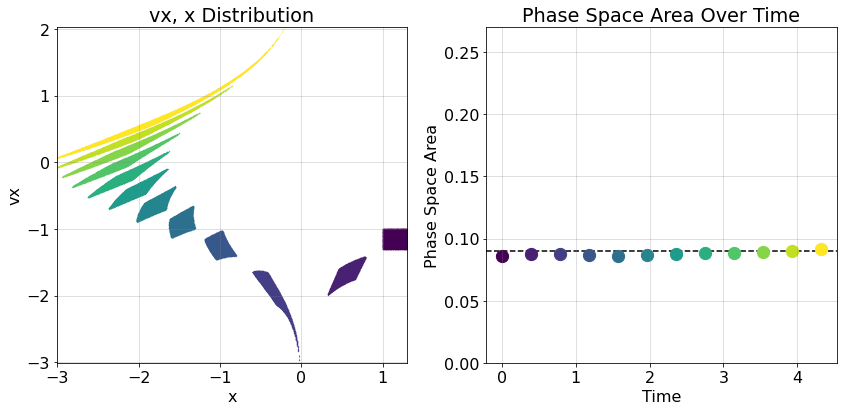

In [160]:
# Set up the logarithmic potential
v0 = 1.0  # Circular velocity
log_potential = dict(type='Logarithmic', v0=v0, axisRatioY=1.0, axisRatioZ=1.0, scaleRadius=0.0)
potential = agama.Potential(log_potential)

# Number of snapshots for plotting
nt = 11

# Number of particles
N = 15000

# Fraction of Tcirc to integrate
fracT = 0.75

# Radial and velocity ranges
r0 = 1.0    # Starting radius
dr = 0.3    # Radial thickness
dv = 0.3    # Velocity thickness

# Initialize positions along x-axis (y = 0, z = 0), directed radially inward
x_i = r0 + dr * np.random.rand(N)  # x in [r0, r0 + dr]
y_i = np.zeros(N)
z_i = np.zeros(N)
positions = np.column_stack((x_i, y_i, z_i))

# Initialize velocities directed toward the center along x-axis
v_i = -(v0 + dv * np.random.rand(N))  # Negative to indicate inward motion
vx_i = v_i
vy_i = np.zeros(N) + 1e-12 # To avoid passing through 0,0
vz_i = np.zeros(N)
velocities = np.column_stack((vx_i, vy_i, vz_i))

# Combine positions and velocities into initial conditions
ic = np.hstack((positions, velocities))

# Compute the circular period at radius r0
T_circ = 2 * np.pi * r0 / v0

# Number of time steps for orbit integration nsteps > nt
nsteps = nt+1

# Integrate the orbits
orbits = agama.orbit(
    potential=potential,
    ic=ic,
    time=fracT * T_circ,
    trajsize=nsteps
)

# Adjust ntimes to ensure it does not exceed nsteps
ntimes = min(nt + 1, nsteps)
indices = np.linspace(0, nsteps - 1, ntimes).astype(int)

# Initialize arrays to store positions and velocities at ntimes
positions_nt = np.zeros((ntimes, N, 3))
velocities_nt = np.zeros((ntimes, N, 3))

# Extract positions and velocities at desired times
for i in range(N):
    trajectory = orbits[i][1]  # Shape: (nsteps, 6)
    positions = trajectory[:, :3]
    velocities = trajectory[:, 3:]
    positions_nt[:, i, :] = positions[indices, :]
    velocities_nt[:, i, :] = velocities[indices, :]

# Extract x positions and vx velocities
x_nt = positions_nt[:, :, 0]
vx_nt = velocities_nt[:, :, 0]

# Define consistent axis limits for vx and x
x_min, x_max = np.min(x_nt), np.max(x_nt)
vx_min, vx_max = np.min(vx_nt), np.max(vx_nt)

# Create colors for each snapshot
colors = plt.cm.viridis(np.linspace(0, 1, ntimes))

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Panel 1: vx, x distribution for all snapshots
ax = axes[0]
ax.set_title('vx, x Distribution')
for t in range(ntimes):
    ax.scatter(x_nt[t], vx_nt[t], s=0.03, color=colors[t], label=f'Time {t}')
ax.set_xlabel('x')
ax.set_ylabel('vx')
ax.set_xlim(x_min, x_max)
ax.set_ylim(vx_min, vx_max)
ax.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

# Panel 2: Phase space area over time, using the same color scheme
# Compute the number of bins needed
nperpixel = 3
npix = np.sqrt((N/nperpixel)*(x_max-x_min)*(vx_max-vx_min)/(dv*dr))
npix = int(npix)
nx = npix
nvx = npix

ax = axes[1]
areas = []
bins_x = np.linspace(x_min, x_max, nx)  # Fixed x bins
bins_vx = np.linspace(vx_min, vx_max, nvx)  # Fixed vx bins

# Compute areas and plot
for t in range(ntimes):
    # Calculate the phase space area with consistent limits
    H, xedges, yedges = np.histogram2d(
        x_nt[t], vx_nt[t], bins=[bins_x, bins_vx], range=[[x_min, x_max], [vx_min, vx_max]]
    )
    dx_bin = xedges[1] - xedges[0]
    dvx_bin = yedges[1] - yedges[0]
    bin_area = dx_bin * dvx_bin
    occupied_bins = np.sum(H > 0)
    area = occupied_bins * bin_area
    areas.append(area)
    ax.scatter(t * fracT * T_circ / ntimes, area, marker='o', color=colors[t], s=150)

ax.set_ylim(0,3*dr*dv)
ax.axhline(y=dr * dv, color='black', linestyle='--', zorder=0)
ax.set_title("Phase Space Area Over Time")
ax.set_xlabel('Time')
ax.set_ylabel('Phase Space Area')
ax.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

# Adjust layout
plt.tight_layout()

plt.savefig("../Figures/phase_space_spiral.png", format="png", 
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()